# Algorithm for a Dog Identification App 

Nowadays, it seems that we have unlimited access to data. Especially when it comes to good quality photos. Each of us has a smartphone that we use to document scenes from our lives. One of the things we love to photograph are our pets.

One of the most popular uses of neural networks (and especially of revolutionary neural networks) is object recognition in photos. The purpose is to conveniently segregate data, create amazing applications of augmented reality or intelligent analysis of monitoring recordings.

In this notebook I will show you how to create a convolution network that can distinguish between 133 different breeds of dogs based on photos.

It's not always that easy! Take a look at these two examples:

![Sample Dog Output1](images/Brittany_02625.jpg) ![Sample Dog Output2](images/Welsh_springer_spaniel_08203.jpg)

One of them is brittany and other is welsh springer spaniel. Can you guess which one is which?

Now you don't have to! Follow cells in this notebook and check it on your own!

In [66]:
import os
from os.path import isfile, isdir
import pathlib
import pickle as pkl
import random
from glob import glob

import collections
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.datasets import load_files
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input

In [67]:
tf.__version__ # make sure that it's higher than 2.0.0

'2.1.0'

Here we are initializing global variables useful in data displaying and learning model

In [68]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

**Set path to dog images**
## Be careful data is not included in this repository! If you want you can download it from web application level or by following link below
<a href="https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip" class="text-white">Download dataset</a>

In [69]:
dogs_dir = "dogImages" # must be in the same folder as notebook
train_dir = dogs_dir + "/train"
test_dir = dogs_dir + "/test"
valid_dir = dogs_dir + "/valid"

# Load and investigate data

In [70]:
image_generator = image.ImageDataGenerator(rescale=1/255)

print("Train data: ")
train_image_data = image_generator.flow_from_directory(str(train_dir), target_size=(IMG_WIDTH, IMG_HEIGHT), batch_size=BATCH_SIZE)
print("Test data: ")
test_image_data = image_generator.flow_from_directory(str(test_dir), target_size=(IMG_WIDTH, IMG_HEIGHT))
print("Validation data: ")
valid_image_data = image_generator.flow_from_directory(str(valid_dir), target_size=(IMG_WIDTH, IMG_HEIGHT))

Train data: 
Found 6680 images belonging to 133 classes.
Test data: 
Found 836 images belonging to 133 classes.
Validation data: 
Found 835 images belonging to 133 classes.


**Ok so we can see that the number of classes is 133, that's quite a lot. Let's see what kind of breeds are available in our dataset.**

In [71]:
num_of_classes = 133

def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = tf.keras.utils.to_categorical(np.array(data['target']), num_of_classes)
    return dog_files, dog_targets


def clean_label(label):
    """Data looks like this '000.some_breed', here we are converting it to 'some breed'"""
    return label.split(".")[1:][0].replace("_", " ")


# load train, test, and validation datasets
# we already know this number from image_generator but we can double check
_, train_targets = load_dataset(train_dir)
_, valid_targets = load_dataset(valid_dir)
_, test_targets = load_dataset(test_dir)

print(f"""Num of train images: {len(train_targets)}
Num of valid images: {len(valid_targets)}
Num of test images: {len(test_targets)}\n""")

num_of_dog_classes = 133
dog_names = [clean_label(item.split('/')[-2]) for item in sorted(glob(f"{train_dir}/*/"))]

print("Sample classes names: ")
shuffled_dog_names = dog_names.copy()
random.shuffle(shuffled_dog_names)
shuffled_dog_names[:10]

Num of train images: 6680
Num of valid images: 835
Num of test images: 836

Sample classes names: 


['Afghan hound',
 'Bulldog',
 'Norwegian buhund',
 'Portuguese water dog',
 'Great dane',
 'Leonberger',
 'Chow chow',
 'American foxhound',
 'Komondor',
 'Neapolitan mastiff']

# So how out images looks like? Check this out!

In [72]:
def show_batch(image_batch, label_batch):
    """Shows batch of images generated by ImageDataGenerator"""
    plt.figure(figsize=(15,15))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        plt.axis('off')
    plt.show()

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 133)


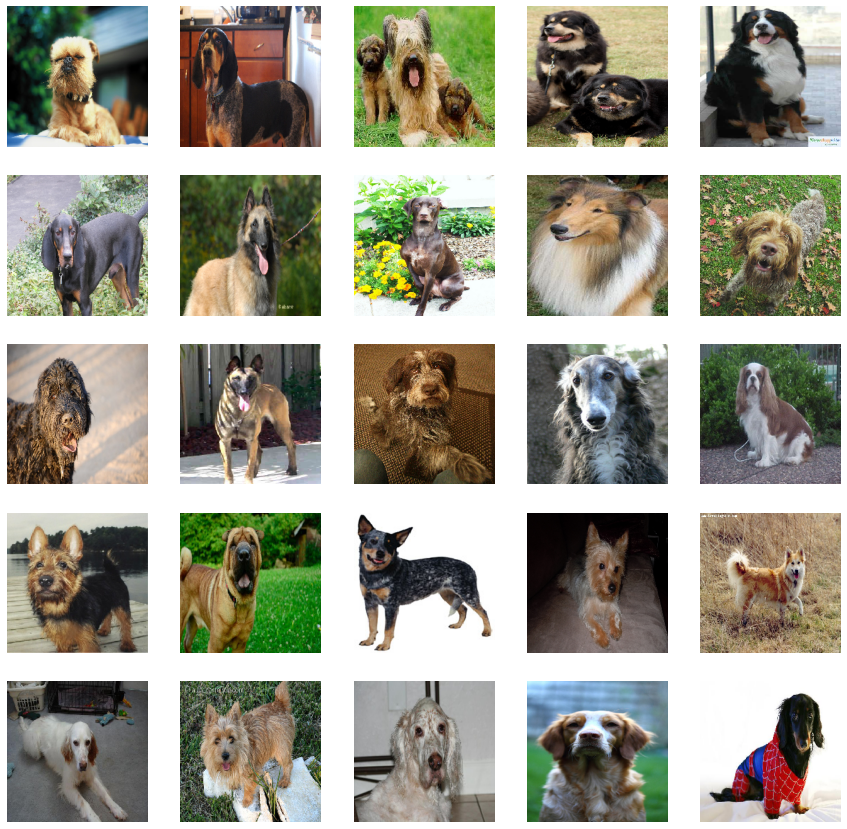

In [73]:
for image_batch, label_batch in train_image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)

    show_batch(image_batch, label_batch)
    break

# That's some nice looking dogs!
**You can continue with using train_image_data initialized before and even augmenting it, but if you want to make things faster load prepared bottleneck features, which are precomputed features for ResNet50 architecture. Either way I will give you opportinity to go both ways.**

In [74]:
# pretrained bottleneck resnet50 reatures
def load_pretrainted_resnet_features(path):
    """Loads and returns precomputed features for ResNet50 architecture"""
    bottleneck_features = np.load(path)

    train_resnet = bottleneck_features['train']
    valid_resnet = bottleneck_features['valid']
    test_resnet = bottleneck_features['test']

    return train_resnet, valid_resnet, test_resnet

train_resnet, valid_resnet, test_resnet = load_pretrainted_resnet_features("../dogs_breed_classifier/data/bottleneck_features/resnet_embeddings.npz")

In [75]:
augmented_image_generator = ImageDataGenerator(
    rescale=1/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Found 6680 images belonging to 133 classes.
Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 133)


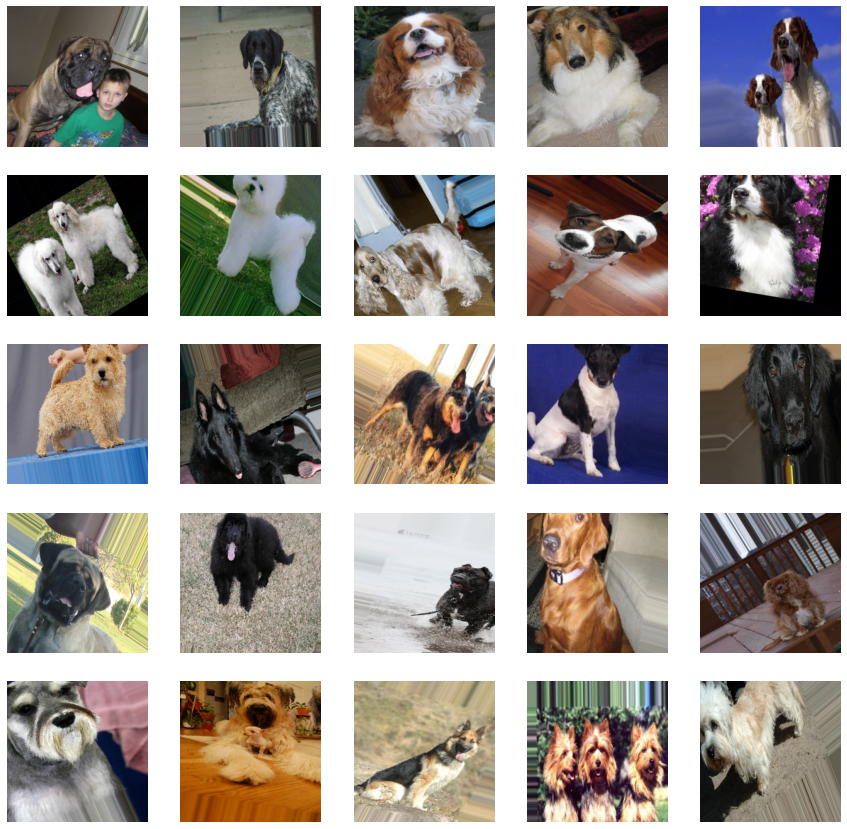

In [76]:
augmented_train = augmented_image_generator.flow_from_directory(train_dir, target_size=(IMG_WIDTH, IMG_HEIGHT) ,batch_size=BATCH_SIZE)
for image_batch, label_batch in augmented_train:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)

    show_batch(image_batch, label_batch)
    break

Nice! Now we are ready to do our training. Lets begin with...

# Creating your model

If you don't want to use bottleneck features download ResNet50 (or any other architecture :)) and add some extra layers at the end, whith 133 classes as output.

In [77]:
pretrained_resnet = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)

In [78]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dense = tf.keras.layers.Dense(512)
dropout = tf.keras.layers.Dropout(0.4)
prediction_layer = tf.keras.layers.Dense(num_of_dog_classes, activation="softmax")

In [79]:
# that's my proposition, you can go wild and be creative!
pretrained_model = tf.keras.Sequential([
    pretrained_resnet,
    global_average_layer,
    dense,
    dropout,
    prediction_layer
])

In [80]:
pretrained_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               68229     
Total params: 24,705,029
Trainable params: 24,651,909
Non-trainable params: 53,120
_________________________________________________________________


In [81]:
pretrained_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

If you don't want to speed up training (or you don't have fast GPU) please use already pretrained features and create model like this:

In [82]:
resnet_model = tf.keras.Sequential([
    global_average_layer,
    dense,
    dropout,
    prediction_layer
])

I will go with faster solution so:

In [83]:
resnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [84]:
def decay(epoch):
    """Learning scheduler, reduces learning rate depending on the epochs"""
    if epoch < 3:
        return 1e-2
    elif epoch >= 3 and epoch < 7:
        return 1e-3
    else:
        return 1e-4

In [85]:
class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        """Shows learning rate during training"""
        print('\nLearning rate for epoch {} is {}'.format(
            epoch + 1, resnet_model.optimizer.lr.numpy()))

In [86]:
checkpoint_dir = "checkpoints"
checkpoint_path = checkpoint_dir + "/weights.best.resnet.hdf5"

if not isdir(checkpoint_dir):
    !mkdir "checkpoints"
else:
    print("Path already exists")

# Create a callback that saves the model's weights
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_best_only=True,
        verbose=1),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR(),
]

Path already exists


In [87]:
bottleneck_features = True
epochs = 15

if bottleneck_features:
    history = resnet_model.fit(
        train_resnet,
        train_targets, 
        validation_data=(
            valid_resnet,
            valid_targets),
        epochs=epochs,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=1,
        )
else:
    history = pretrained_model.fit(
        augmented_train,
        validation_data=valid_image_data,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1,
    )

Train on 6680 samples, validate on 835 samples
Epoch 1/15
6464/6680 [============================>.] - ETA: 0s - loss: 32.4923 - accuracy: 0.3933
Epoch 00001: val_loss improved from inf to 36.17736, saving model to checkpoints/weights.best.resnet.hdf5

Learning rate for epoch 1 is 0.009999999776482582
6680/6680 [==============================] - 1s 188us/sample - loss: 33.0354 - accuracy: 0.3957 - val_loss: 36.1774 - val_accuracy: 0.5281
Epoch 2/15
6464/6680 [============================>.] - ETA: 0s - loss: 42.8079 - accuracy: 0.5886
Epoch 00002: val_loss did not improve from 36.17736

Learning rate for epoch 2 is 0.009999999776482582
6680/6680 [==============================] - 1s 144us/sample - loss: 43.2844 - accuracy: 0.5912 - val_loss: 43.6034 - val_accuracy: 0.6563
Epoch 3/15
6560/6680 [============================>.] - ETA: 0s - loss: 45.4475 - accuracy: 0.6841
Epoch 00003: val_loss did not improve from 36.17736

Learning rate for epoch 3 is 0.009999999776482582
6680/6680 [====

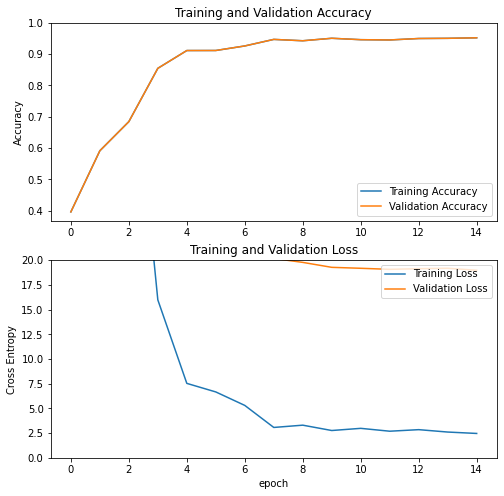

In [88]:
acc = history.history['accuracy']
val_acc = history.history['accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,20.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [89]:
resnet_model.load_weights(checkpoint_path)

# Evaluation

In [90]:
resnet_predictions = [np.argmax(resnet_model.predict(np.expand_dims(feature, axis=0))) for feature in test_resnet]

test_accuracy = 100 * np.sum(np.array(resnet_predictions)==np.argmax(test_targets, axis=1)) / len(resnet_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 84.0909%


That's pretty high accuracy for 133 classes. But can you do better?

In [91]:
def extract_resnet50(tensor):
    """Converts image tensor to resnet bottleneck feature"""
    return tf.keras.applications.ResNet50(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

In [92]:
def resnet_predict_breed(img_path):
    """Predics dog breed on image from image_path"""
    # extract bottleneck features
    bottleneck_feature = extract_resnet50(path_to_tensor(img_path))
    # obtain predicted vecto
    predicted_vector = resnet_model.predict(bottleneck_feature)[0]

    # return dog breed that is predicted by the model
    indices = predicted_vector.argsort()[-3:][::-1]
    names = [dog_names[index] for index in indices]
    percentages = [100 * predicted_vector[index] for index in indices]
    
    return names, percentages

# Extra: Recognize if there is a man in the picture and tell which dog he is most like

Number of faces detected: 1


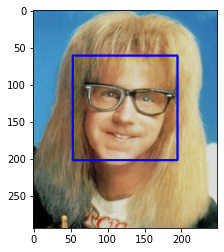

In [93]:
import cv2                      
%matplotlib inline                    

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('../dogs_breed_classifier/data/cascade_classifier/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread("images/sample_human_2.png")
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [94]:
def face_detector(img_path, facecascade):
    """Detects human faces, returns true if face will be found at image"""
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = facecascade.detectMultiScale(gray)
    return len(faces) > 0

In [95]:
imagenet_resnet = tf.keras.applications.ResNet50(weights='imagenet')

def path_to_tensor(img_path):
    """Converts image path to image tensor"""
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def dog_detector(img_path):
    """Detects if there is dog at the image"""
    img = preprocess_input(path_to_tensor(img_path))
    prediction = np.argmax(imagenet_resnet.predict(img))

    return ((prediction <= 268) & (prediction >= 151))

# Now it's time to check our model in practice!

In [96]:
def make_predictions(img_path):
    """
    Given model and image path predicts if there is human or dog on the image.
    Either way it predicts what breed of dog is it (or could be).
    """
    if face_detector(img_path, face_cascade):
        names, percentages = resnet_predict_breed(img_path)
        answer = ""
        for name, percent in zip(names, percentages):
            answer += f"\n{name} ({percent:.4} %)"
        response = f"I'm pretty sure that's human!\nBut as a dog it could be... {answer}"
    elif dog_detector(img_path):
        names, percentages = resnet_predict_breed(img_path)
        answer = ""
        for name, percent in zip(names, percentages):
            answer += f"\n{name} ({percent:.4} %)"
        response = f"That's a dog! and he looks like... {answer}"
    else:
        response = "I can't recognize what is that :<"
        
    plt.figure(figsize=(5, 5))
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(response)
    plt.axis('off')
    plt.show()

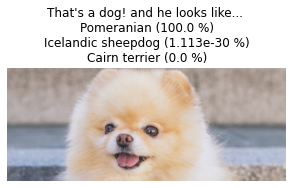

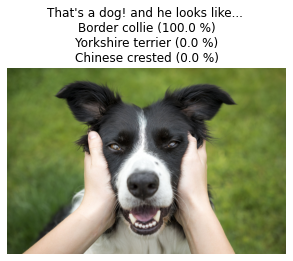

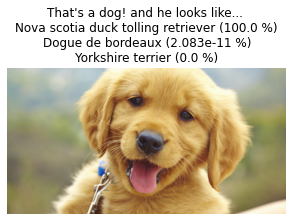

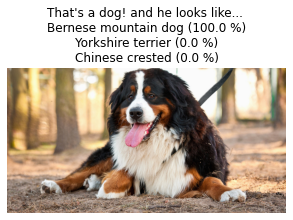

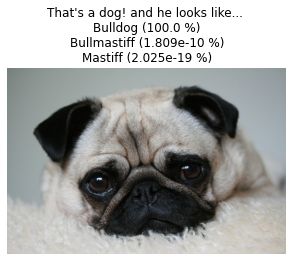

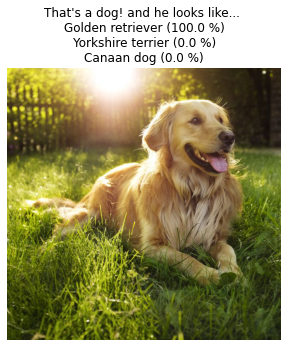

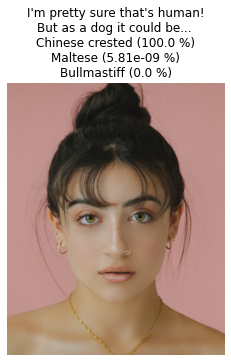

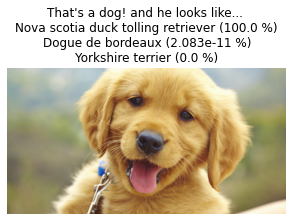

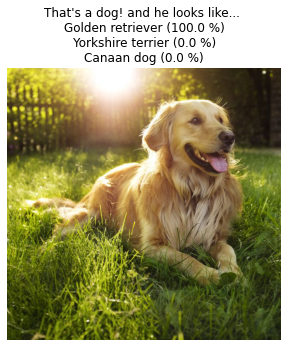

In [98]:
for path in pathlib.Path("uploaded_images").glob("**/*.jpg"):
    make_predictions(str(path))